# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from typing import Dict, List, Tuple
import pandas as pd
import os
from collections import defaultdict
import cvxpy as cp
from skimage.filters import threshold_otsu
import logging
from dataclasses import dataclass
import json
import glob
from joblib import Parallel, delayed
from tqdm import tqdm
import time

# Setup

In [2]:
try:
    CURRENT_DIRECTORY = os.path.dirname(os.path.abspath(__file__))
except NameError:
    CURRENT_DIRECTORY = os.getcwd()
    
SIMULATION_DIRECTORY = os.path.join(CURRENT_DIRECTORY, '')
RESULTS_DIRECTORY = os.path.join(SIMULATION_DIRECTORY, 'results')
PLOT_DIRECTORY = os.path.join(SIMULATION_DIRECTORY, 'plots')

# Ensure directories exist
os.makedirs(RESULTS_DIRECTORY, exist_ok=True)
os.makedirs(PLOT_DIRECTORY, exist_ok=True)

# Setup logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filename=os.path.join(SIMULATION_DIRECTORY, 'simulation_log.txt'),
                    filemode='w')
logger = logging.getLogger(__name__)

# Hyper Parameters

In [3]:
NUMBER_ORIGINAL_SAMPLES = 1758
GAUSSIAN_SIGMA = NUMBER_ORIGINAL_SAMPLES / 100

# Algorithm 1

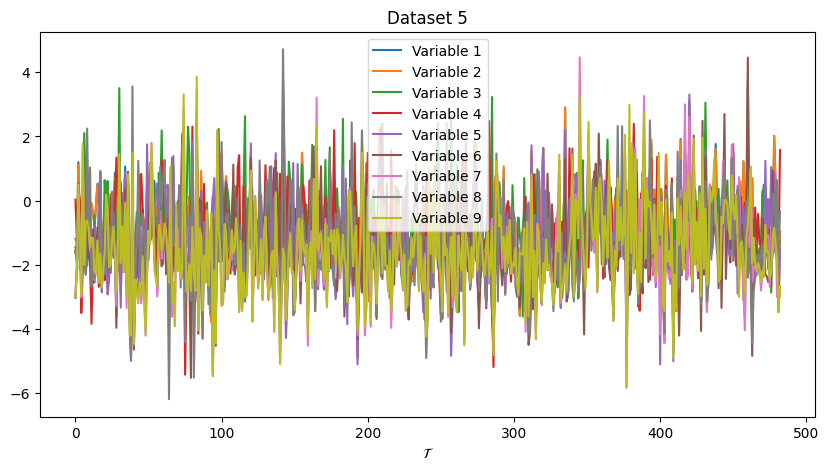

Evaluating lambda pairs:   2%|▎         | 40/1600 [00:21<19:35,  1.33it/s]

In [4]:
@dataclass
class SimulationParams:
    gaussian_sigma: float
    total_original_samples: int

def fused_lasso(data, m, lambda1_value, lambda2_value, return_all: bool = False):
    """
    TODO
    """
    n, p = data.shape
    y = data[:, m].astype(np.float64)
    X = np.delete(data.copy(), m, axis=1).T.astype(np.float64)
    
    lambda1 = cp.Parameter(nonneg=True)
    lambda2 = cp.Parameter(nonneg=True)
    beta = cp.Variable((p-1, n))
    
    lasso_penalty = cp.norm1(beta)
    fusion_penalty = cp.sum([cp.norm2(beta[:, i] - beta[:, i-1]) for i in range(1, n)])
    loss = cp.sum_squares(y - cp.sum(cp.multiply(X, beta), axis=0))
    
    objective = cp.Minimize(loss + (2 * lambda1 * fusion_penalty) + (2 * lambda2 * lasso_penalty))
    problem = cp.Problem(objective)
    
    lambda1.value = lambda1_value
    lambda2.value = lambda2_value
    
    problem.solve()
    
    beta_estimated = beta.value
    loss_value = loss.value
    penalty = (2 * lambda1.value * fusion_penalty.value) + (2 * lambda2.value * lasso_penalty.value)
    
    if return_all:
        return beta_estimated, loss_value, penalty
    return beta_estimated

def calculate_differences(beta_estimated):
    """
    TODO
    """
    return np.abs(np.diff(beta_estimated, axis=1))

def calculate_BIC(loss, beta_estimated, n_samples):
    """
    TODO
    """
    first_differences = calculate_differences(beta_estimated)
    bic = n_samples * np.log(loss / n_samples) + (np.sum(np.abs(first_differences) > 1e-6) * np.log(n_samples) * np.log(np.log(first_differences.shape[1])))
    return bic

def evaluate_params(lambda1_value, lambda2_value, transformed_data, n_transformed_samples, d):
    """
    TODO
    """
    total_BIC = 0
    for m in range(d-1):
        beta_estimated, loss, penalty = fused_lasso(transformed_data, m, lambda1_value, lambda2_value, return_all=True)
        bic = calculate_BIC(loss, beta_estimated, n_transformed_samples)
        total_BIC += bic
    return lambda1_value, lambda2_value, total_BIC

def get_lambda_range(lambda_theoretical: float, n_points: int = 10) -> list:
    """
    TODO
    """
    lower_bound_lambda = (1/3) * lambda_theoretical
    upper_bound_lambda = 3 * lambda_theoretical

    lambda_range = np.linspace(lower_bound_lambda, upper_bound_lambda, num=n_points)

    return lambda_range

def get_regularization_params(transformed_data, n_transformed_samples):
    """
    TODO
    """
    d = transformed_data.shape[1] + 1
    lambda1_theoretical = 1 * n_transformed_samples ** (1/2)
    lambda2_theoretical = 2 * np.sqrt(np.log(d-1) / n_transformed_samples)

    lambda1_range = get_lambda_range(lambda1_theoretical, n_points=40)
    lambda2_range = get_lambda_range(lambda2_theoretical, n_points=40)

    lambda_combinations = [(l1, l2) for l1 in lambda1_range for l2 in lambda2_range]
    
    start_time = time.time()
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_params)(l1, l2, transformed_data, n_transformed_samples, d)
        for l1, l2 in tqdm(lambda_combinations, desc="Evaluating lambda pairs")
    )
    end_time = time.time()
    logger.info(f"Parameter evaluation completed in {end_time - start_time:.2f} seconds")
    
    best_lambda1, best_lambda2, best_BIC_sum = min(results, key=lambda x: x[2])
    
    logger.info(f"Optimal lambda1: {best_lambda1}, lambda2: {best_lambda2}")
    return best_lambda1, best_lambda2

def compute_tilde_S(dataframe: pd.DataFrame, params: SimulationParams) -> Tuple[np.ndarray, float, float, Dict, Dict, Dict]:
    """
    TODO
    """
    logger.info(f"Computing tilde_S for dataframe with shape: {dataframe.shape}")
    transformed_data = dataframe.iloc[:, 1:].values
    original_index = dataframe.iloc[:, 0].values - 1
    d = transformed_data.shape[1] + 1
    n_transformed_samples = transformed_data.shape[0]
    
    lambda1_m, lambda2_m = get_regularization_params(transformed_data, n_transformed_samples)
    
    beta_hat_m = {}
    beta_hat_m_differences = {}
    for k in range(d-1):
        beta_hat_m[k] = fused_lasso(transformed_data, k, lambda1_m, lambda2_m)
        beta_hat_m_differences[k] = calculate_differences(beta_hat_m[k])
        beta_hat_m_differences[k] = np.insert(beta_hat_m_differences[k], 0, 0, axis=1)
    
    beta_differences_original_index = defaultdict(lambda: np.zeros(params.total_original_samples))
    for k in range(d-1):
        for i, difference in enumerate(beta_hat_m_differences[k].T):
            beta_differences_original_index[k][original_index[i]] = np.sum(difference)
    
    tilde_S = np.zeros(params.total_original_samples)
    for differences_array in beta_differences_original_index.values():
        tilde_S += differences_array
    
    return tilde_S, lambda1_m, lambda2_m, beta_hat_m, beta_hat_m_differences, beta_differences_original_index

def compute_dot_S(tilde_S):
    """
    TODO
    """
    dot_S = np.zeros(next(iter(tilde_S.values())).shape[0])
    for tilde_S_k in tilde_S.values():
        dot_S += tilde_S_k
    return dot_S

def estimate_changepoints(
        dot_S: np.ndarray, 
        params: SimulationParams, 
        min_threshold: float = 0
    ) -> Tuple[List[int], np.ndarray, float, np.ndarray]:
    """
    TODO
    """
    logger.info("Estimating changepoints")
    smoothed_data = gaussian_filter1d(dot_S, params.gaussian_sigma)
    threshold = threshold_otsu(smoothed_data)
    threshold = max(threshold, min_threshold)
    peaks, _ = find_peaks(smoothed_data, height=threshold)
    logger.info(f"Estimated {len(peaks)} changepoints")
    return peaks.tolist(), smoothed_data, threshold, peaks

def plot_changepoint_estimation(
        dot_S: np.ndarray, 
        smoothed_data: np.ndarray, 
        peaks: List[int], threshold: float,
        sim: int, 
        plot_directory: str,
        true_changepoints: List[int]
    ):
    """
    TODO
    """
    plt.figure(figsize=(15, 6))
    plt.plot(dot_S, label='Non-Smoothed')
    plt.plot(smoothed_data, label='Smoothed', linewidth=2)
    plt.scatter(peaks, smoothed_data[peaks], color='red', label='Estimated Peaks')
    plt.axhline(y=threshold, color='gray', linestyle='--', label='Threshold')
    
    for cp in true_changepoints:
        plt.axvline(x=cp, color='red', linestyle=':', linewidth=2, label='True Changepoint')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.title(f'Changepoint Estimation - Simulation {sim}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    
    filename = os.path.join(plot_directory, f'changepoint_estimation_sim{sim}.png')
    plt.savefig(filename)
    plt.close()
    logger.info(f"Changepoint estimation plot saved as '{filename}'")

def run_single_simulation(
        sim: int, 
        dataframes: Dict[int, pd.DataFrame], 
        true_changepoints: List[int], 
        params: SimulationParams,
        plot_directory: str
    ) -> Dict:
    """
    TODO
    """
    logger.info(f"Running Simulation {sim}")
    
    tilde_S_dict = {}
    lambda_pairs = []

    d = len(dataframes)
    for m, df in dataframes.items():
        logger.info(f"Analyzing Dataset {m}")
        tilde_S_m, lambda1_m, lambda2_m, _, _, _ = compute_tilde_S(df, params)
        tilde_S_dict[m] = tilde_S_m
        lambda_pairs.append((lambda1_m, lambda2_m))
    
    dot_S = compute_dot_S(tilde_S_dict)
    
    min_threshold = 2.5e-4 * d * (d-1) # \tau_min
    
    estimated_changepoints, smoothed_data, threshold, peaks = estimate_changepoints(dot_S, params, min_threshold=min_threshold)
    
    plot_changepoint_estimation(dot_S, smoothed_data, estimated_changepoints, threshold, 
                                sim, plot_directory, true_changepoints)
    
    results = {
        'simulation': sim,
        'lambda_pairs': lambda_pairs,
        'threshold': threshold,
        'estimated_changepoints': estimated_changepoints,
        'true_changepoints': true_changepoints
    }
    
    return results

def main(dataframes: Dict[int, pd.DataFrame], true_changepoints: List[int], simulation_id: int):
    """
    TODO
    """
    params = SimulationParams(
        gaussian_sigma=GAUSSIAN_SIGMA,
        total_original_samples=NUMBER_ORIGINAL_SAMPLES
    )
    
    logger.info(f"Starting simulation: {simulation_id}")
    logger.info(f"Simulation parameters: {params}")
    
    results = run_single_simulation(
        simulation_id, dataframes, true_changepoints, params, plot_directory=PLOT_DIRECTORY
    )
    
    with open(os.path.join(RESULTS_DIRECTORY, f'simulation_results_{simulation_id}.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    logger.info(f"Simulation {simulation_id} completed. Results saved.")

def load_data(directory_path: str) -> Dict[int, pd.DataFrame]:
    """
    TODO
    """
    csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
    dataframes = {}
    for file in csv_files:
        df = pd.read_csv(file)
        node_number = int(os.path.basename(file).split('.')[0][4:])
        dataframes[node_number] = df
        logger.debug(f'DataFrame for Node {node_number} loaded successfully')
    return dataframes

def display_data(dataframes: Dict[int, pd.DataFrame], max_plots: int = None):
    """
    TODO
    """
    count = 0
    for k, df in dataframes.items():
        plt.figure(figsize=(10, 5))
        for i in range(len(df.columns) - 1):
            plt.plot(df.iloc[:, 1:].values[:, i], label=f'Variable {i+1}')
        plt.title(f'Dataset {k}')
        plt.legend()
        plt.xlabel('$\\mathcal{T}$')
        plt.show()
        logger.info(f'Plot created for DataFrame {k}')

        count += 1

        if max_plots is not None and count >= max_plots:
            break

if __name__ == "__main__":
    # Define path to directory containing transformed datasets
    directory_path = 'data/currency_data_subset_approximate_sample_transformed_subset/'
    # Load datasets into a dictionary of dataframes
    dataframes = load_data(directory_path)
    # Visualise datasets
    display_data(dataframes, max_plots=1)

    simulation_id = 1
    # No true change points are known, so pass empty list
    true_changepoints = []
    main(dataframes, true_changepoints, simulation_id)